## Libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import sys
import spacy  # just for NLP
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import tqdm

from sklearn.utils import resample 
from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from utils import *
from data_utils import *
from train_utils import *


# setup
NLP = spacy.load('en_core_web_sm')  # NLP toolkit

## Dataset

In [3]:

train_df = pd.read_csv( 'dataset/train.txt', sep=';', names=['content', 'sentiment'], header=0)
test_df = pd.read_csv( 'dataset/test.txt', sep=';', names=['content', 'sentiment'], header=0)
valid_df = pd.read_csv( 'dataset/val.txt', sep=';', names=['content', 'sentiment'], header=0)



In [7]:
# Convert to one dataframe
data = pd.concat([train_df, test_df, valid_df], axis=0)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    19997 non-null  object
 1   sentiment  19997 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


In [8]:
# Saving the DataFrame as a csv file
data.to_csv("dataset/tweet_data_df.csv", index=False)


In [9]:
# Dividing the cvs file to distict folders with lable emotion
input_folder = "dataset/tweet_data_df.csv"
output_folder="dataset/reduces_dataset"
covert_dataframe_to_devided_folder(input_folder, output_folder)


In [10]:
# Removing folder as named sentiment 
import shutil
directory="/output_folder/sentiment"
shutil.rmtree("dataset/reduces_dataset/sentiment")

In [11]:


import splitfolders
input_folder='dataset/reduces_dataset'
splitfolders.ratio(input_folder, output="dataset/aclImdb/", seed=1337, ratio=(0.60, 0.2, 0.2)) 

Copying files: 19997 files [04:18, 77.24 files/s] 


## Data Pre-processing

## Tokenizing

### Tokenizer and Vocabulary

We have defined a function in `utils.py`, which gets the inputs text and splits it to a sequence of tokens. We have used **SpaCy** toolkit for tokeniztion and you need to install it to run the codes.

```python
def tokenizer(text):
    text = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;]", " ", str(text))
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub(r"\!+", "!", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\?+", "?", text)
    return [x.text for x in NLP.tokenizer(text) if x.text != " "]
```

In [12]:
data_dir="dataset/aclImdb/"
os.listdir(data_dir)

['test', 'train', 'val']

### Statistics

In [13]:
#from tqdm.notebook import trange, tqdm


all_filenames = glob(f'{data_dir}/*/*/*.txt')
num_words = [len(open(f, encoding="utf-8").read().split(' ')) for f in tqdm.notebook.tqdm(all_filenames)]

# print statistics
print('Min length =', min(num_words))
print('Max length =', max(num_words))

print('Mean = {:.2f}'.format(np.mean(num_words)))
print('Std  = {:.2f}'.format(np.std(num_words)))

print('mean + 2 * sigma = {:.2f}'.format(np.mean(num_words) + 2.0 * np.std(num_words)))

  0%|          | 0/19997 [00:00<?, ?it/s]

Min length = 2
Max length = 66
Mean = 19.14
Std  = 10.97
mean + 2 * sigma = 41.08


## Dataset

In [15]:



vocab_path = 'vocab.pkl'

# parameters
max_len = 66  # By this initilazatio we consider just 200 character of each text. we determine based on mean + 2 * sigma
min_count = 2     #we replace every token which repeat less than 10 times with the spetial token. This is UNK = '<unk>'. 
batch_size = 64

In [16]:
PAD = '<pad>'  # special symbol we use for padding text
UNK = '<unk>'  # special symbol we use for rare or unknown word

In [17]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, path, tokenizer, 
                 split='train', 
                 vocab_path='vocab.pkl', 
                 max_len=max_len, min_count=min_count):
        
        self.path = path
        assert split in ['train', 'test']
        self.split = split
        self.vocab_path = vocab_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_count = min_count
        
        self.cache = {}
        self.vocab = None
        
        self.classes = []
        self.class_to_index = {}
        self.text_files = []
        
        split_path = f'{path}/{split}'
        
        for cls_idx, label in enumerate(os.listdir(split_path)):
            text_files = [(fname, cls_idx) for fname in glob(f'{split_path}/{label}/*.txt')]
            self.text_files += text_files
            self.classes += [label]
            self.class_to_index[label] = cls_idx
        
        self.num_classes = len(self.classes)
            
        # build vocabulary from training and validation texts
        self.build_vocab()
        
    def __getitem__(self, index):
        # read the tokenized text file and its label (neg=0, pos=1)
        fname, class_idx = self.text_files[index]
        
        if fname in self.cache:
            return self.cache[fname], class_idx
        
        # read text file 
        text = open(fname, encoding="utf-8").read()
        
        # tokenize the text file
        tokens = self.tokenizer(text.lower().strip())
        
        # padding and trimming
        if len(tokens) < self.max_len:
            num_pads = self.max_len - len(tokens)
            tokens = [PAD] * num_pads + tokens
        elif len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            
        # numericalizing
        ids = torch.LongTensor(self.max_len)
        for i, word in enumerate(tokens):
            if word not in self.vocab.word2index:
                ids[i] = self.vocab.word2index[UNK]  # unknown words
            elif word != PAD and self.vocab.word2count[word] < self.min_count:
                ids[i] = self.vocab.word2index[UNK]  # rare words
            else:
                ids[i] = self.vocab.word2index[word]
                
        # save in cache for future use
        self.cache[fname] = ids
        
        return ids, class_idx
    
    def __len__(self):
        return len(self.text_files)
    
    def build_vocab(self):
        if not os.path.exists(self.vocab_path):
            vocab = Vocabulary(self.tokenizer)
            filenames = glob(f'{self.path}/*/*/*.txt')
            for filename in tqdm.notebook.tqdm(filenames, desc='Building Vocab'):
                with open(filename, encoding='utf8') as f:
                    for line in f:
                        vocab.add_sentence(line.lower())

            # sort words by their frequencies
            words = [(0, PAD), (0, UNK)]
            words += sorted([(c, w) for w, c in vocab.word2count.items()], reverse=True)

            self.vocab = Vocabulary(self.tokenizer)
            for i, (count, word) in enumerate(words):
                self.vocab.word2index[word] = i
                self.vocab.word2count[word] = count
                self.vocab.index2word[i] = word
                self.vocab.count += 1

            pickle.dump(self.vocab, open(self.vocab_path, 'wb'))
        else:
            self.vocab = pickle.load(open(self.vocab_path, 'rb'))

In [18]:
train_ds = TextClassificationDataset(data_dir, tokenizer, 'train', vocab_path, max_len, min_count)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TextClassificationDataset(data_dir, tokenizer, 'test', vocab_path, max_len, min_count)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [19]:
len(train_ds)

11995

In [20]:
len(valid_ds)

4006

In [21]:
train_ds.classes

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [22]:
train_ds.class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [23]:
ids, label = train_ds[2]

print(train_ds.classes[label])
print(ids.numpy())

anger
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    2    3   14   84   64    7
  658  630    9    2   15 3189    7   96    1   32   24    1    1   35
    6    1    9   21   11    1 1259   37  487  406]


In [24]:
# convert back the sequence of integers into original text
print(' '.join([train_ds.vocab.index2word[i.item()] for i in ids]))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> i feel like there s a dangerous chance that i m pulling a don <unk> on this <unk> <unk> at the <unk> that is my <unk> marriage or future child


In [25]:
# print the original text
print(open(train_ds.text_files[0][0]).read())

i feel about this totally and completely pissed angry sad disappointed and absolutely furious at tough mudder the biggest rip off on planet earth


### Vovcabulary size

In [26]:
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= min_count]
vocab_size = len(freqs) + 2  # for PAD and UNK tokens
print(f'Vocab size = {vocab_size}')

print('\nMost common words:')
for c, w in sorted(freqs, reverse=True)[:10]:
    print(f'{w}: {c}')

Vocab size = 4049

Most common words:
i: 10763
feel: 4169
and: 3585
to: 3340
the: 3149
a: 2318
feeling: 1945
that: 1886
of: 1785
my: 1599


## LSTM Classifier with Attention mechanism

In [27]:
# Attention computes a weighted average of the hidden states of the LSTM Model.
# In fact, it produce a weight for each hidden state at different time steps

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            #n.BatchNorm1d(60),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )
    
    def forward(self, encoder_outputs):
        # encoder_outputs = [batch size, sent len, hid dim]
        energy = self.projection(encoder_outputs)
        # energy = [batch size, sent len, 1]
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # weights = [batch size, sent len]
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        # outputs = [batch size, hid dim]
        return outputs, weights

    
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,  dropout):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embed_size
        self.num_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, 
                            dropout= 0.2 if n_layers < 2 else dropout)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        #for name, param in self.lstm.named_parameters():
         #   if 'weight' in name:
          #      param = nn.Parameter(param + l2_reg * torch.norm(param))
        
    def forward(self, x):
        # x = [sent len, batch size]
        embedded = self.embedding(x)
        # embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.lstm(embedded)
        # use 'batch_first' if you want batch size to be the 1st para
        # output = [sent len, batch size, hid dim*num directions]
        output = output[:, :, :self.hidden_dim] + output[:, :, self.hidden_dim:]
        # output = [sent len, batch size, hid dim]
        ouput = output.permute(1, 0, 2)
        # ouput = [batch size, sent len, hid dim]
        new_embed, weights = self.attention(ouput)
        # new_embed = [batch size, hid dim]
        # weights = [batch size, sent len]
        new_embed = self.dropout(new_embed)
        return self.fc(new_embed)

In [28]:
vocab_size = 2 + len([w for (w, c) in train_ds.vocab.word2count.items() if c >= min_count])
print(vocab_size)

4049


## Model

In [29]:
# LSTM parameters
embed_size = 100
hidden_size = 256
num_layers = 4

# training parameters
learning_rate = 0.001
num_epochs =10
l2_reg=0.001

In [30]:
model = AttentionLSTM(vocab_size, embed_size, hidden_size,
                      output_dim=train_ds.num_classes, 
                      n_layers=num_layers, bidirectional=True, dropout=0.3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model

AttentionLSTM(
  (embedding): Embedding(4049, 100)
  (lstm): LSTM(100, 256, num_layers=4, dropout=0.3, bidirectional=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [31]:
criterion = nn.CrossEntropyLoss().to(device)
criterion = criterion.to(device)
    
optimizer = optim.Adam(model.parameters(), betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

### Training

In [32]:
hist = train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs)

[Epoch:  1/10] | Training Loss: 0.0241 | Testing Loss: 0.0209 | Training Acc:           35.39 | Testing Acc: 45.69
[Epoch:  2/10] | Training Loss: 0.0147 | Testing Loss: 0.0092 | Training Acc:           64.59 | Testing Acc: 79.23
[Epoch:  3/10] | Training Loss: 0.0067 | Testing Loss: 0.0060 | Training Acc:           84.96 | Testing Acc: 86.57
[Epoch:  4/10] | Training Loss: 0.0040 | Testing Loss: 0.0045 | Training Acc:           90.87 | Testing Acc: 88.71
[Epoch:  5/10] | Training Loss: 0.0029 | Testing Loss: 0.0041 | Training Acc:           92.85 | Testing Acc: 90.35
[Epoch:  6/10] | Training Loss: 0.0023 | Testing Loss: 0.0038 | Training Acc:           93.89 | Testing Acc: 91.05
[Epoch:  7/10] | Training Loss: 0.0018 | Testing Loss: 0.0045 | Training Acc:           95.06 | Testing Acc: 90.20
[Epoch:  8/10] | Training Loss: 0.0016 | Testing Loss: 0.0041 | Training Acc:           95.61 | Testing Acc: 91.20
[Epoch:  9/10] | Training Loss: 0.0014 | Testing Loss: 0.0043 | Training Acc:   

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

In [33]:
train_hist, valid_hist=hist

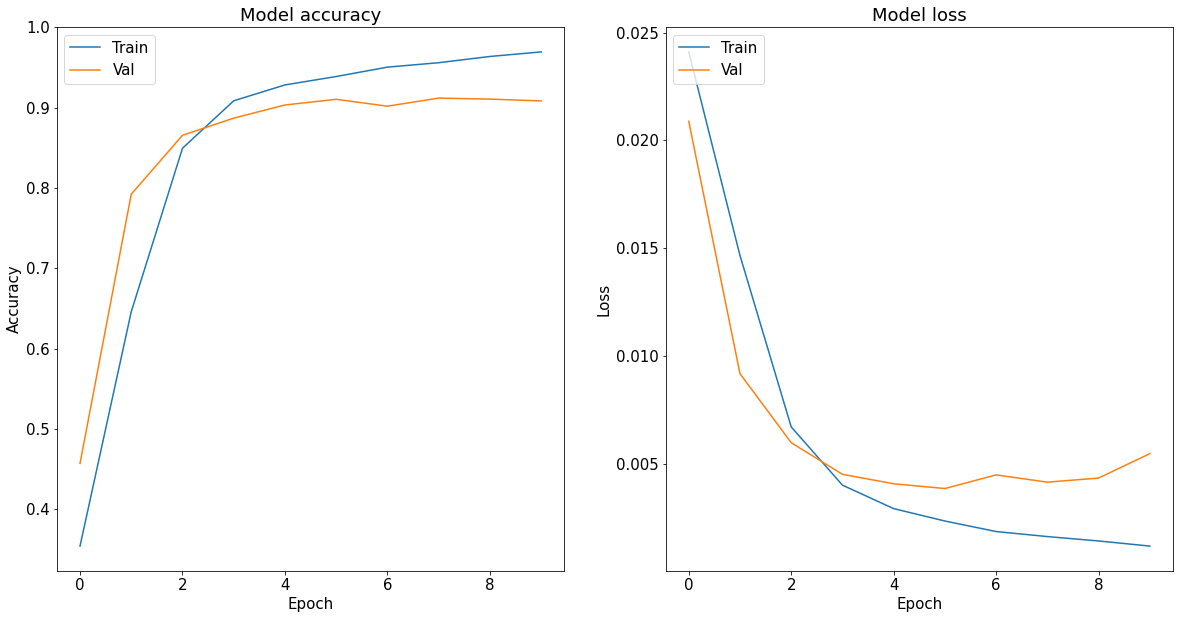

In [34]:
# Plot training and validation accuracy and loss in one figure

train_loss=[x[0] for x in train_hist]
val_loss=[x[0] for x in valid_hist]
train_accuracy=[x[1] for x in train_hist]
val_accuracy=[x[1] for x in valid_hist]



plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15})

plt.subplot(1, 2, 1)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')



plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('Images/LSTM_Accuracy_Loss.png')

plt.show()

In [35]:
#Evaluateion model on test set

test_ds = TextClassificationDataset(data_dir, tokenizer, 'test', vocab_path, max_len, min_count)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
test_loss,test_acc, test_confusion_matrix= test(model,test_dl, criterion, device)

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

In [36]:
# Print the metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')
#print(f'Test F1-score: {test_f1:.4f}')



Test loss: 0.0055
Test accuracy: 0.9080


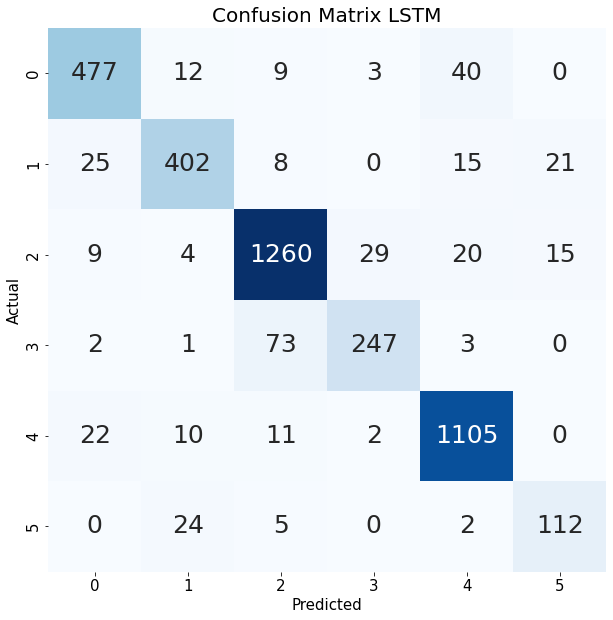

In [37]:
# Plot the confusion matrix
fig, ax =plt.subplots(figsize=(10,10))
sns.heatmap(test_confusion_matrix, annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
plt.title('Confusion Matrix LSTM', fontsize=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/Confusion_Matrix_LSTM.png')
plt.show()